--- Running Step 3: Dataset Analysis and Manual Reweighting ---

[Step 3.1] Loading and Preparing Data...
Dataset loaded successfully.

--- Initial Data Summary ---
Original dataset shape: (109250, 26)

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109250 entries, 0 to 109249
Columns: 26 entries, lei to derived_sex_encoded
dtypes: float64(5), int64(6), object(15)
memory usage: 21.7+ MB

Value Counts for Action Taken:
action_taken
1    66911
3    17876
4    15723
5     5695
2     2842
8      144
7       59
Name: count, dtype: int64

Dependent variables prepared.

Dropped 4419 rows with missing values in feature columns to prepare for modeling.
Shape of data ready for modeling: (104831, 27)

--- Protected Class Subgroup Counts ---

Sex Analysis Subgroups (sex_df):
applicant_sex
Male      68120
Female    36442
Name: count, dtype: int64

Race Analysis Subgroups (race_df):
derived_race_new
White                        75422
Black or African American    19982
Name: count, dtyp

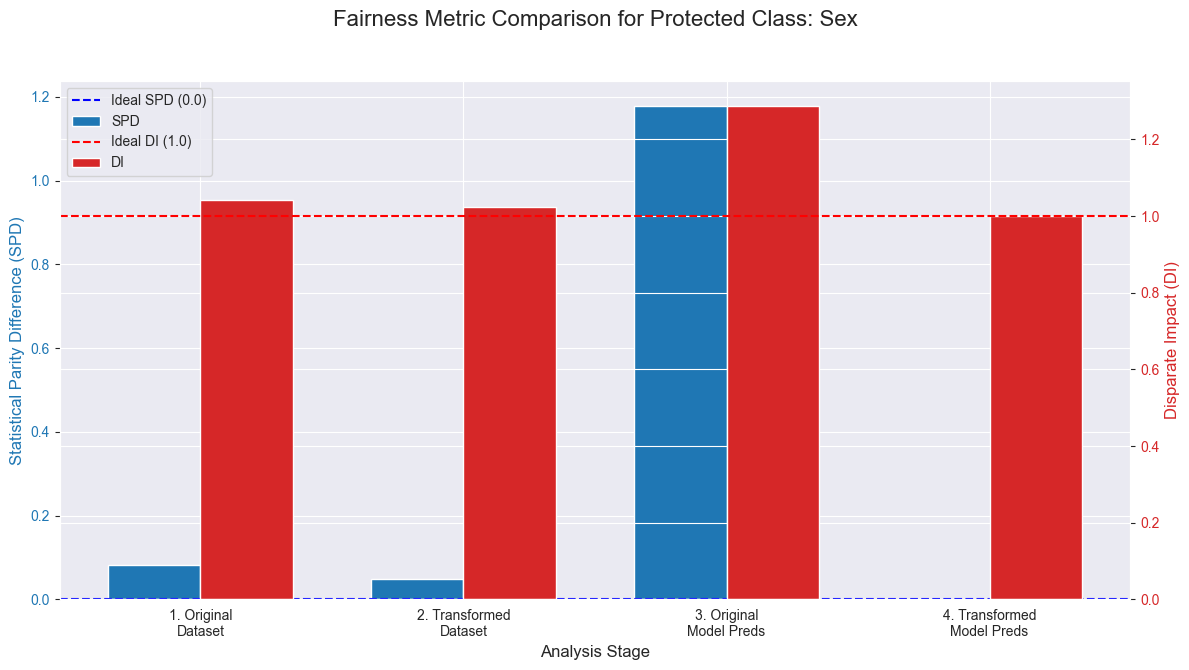

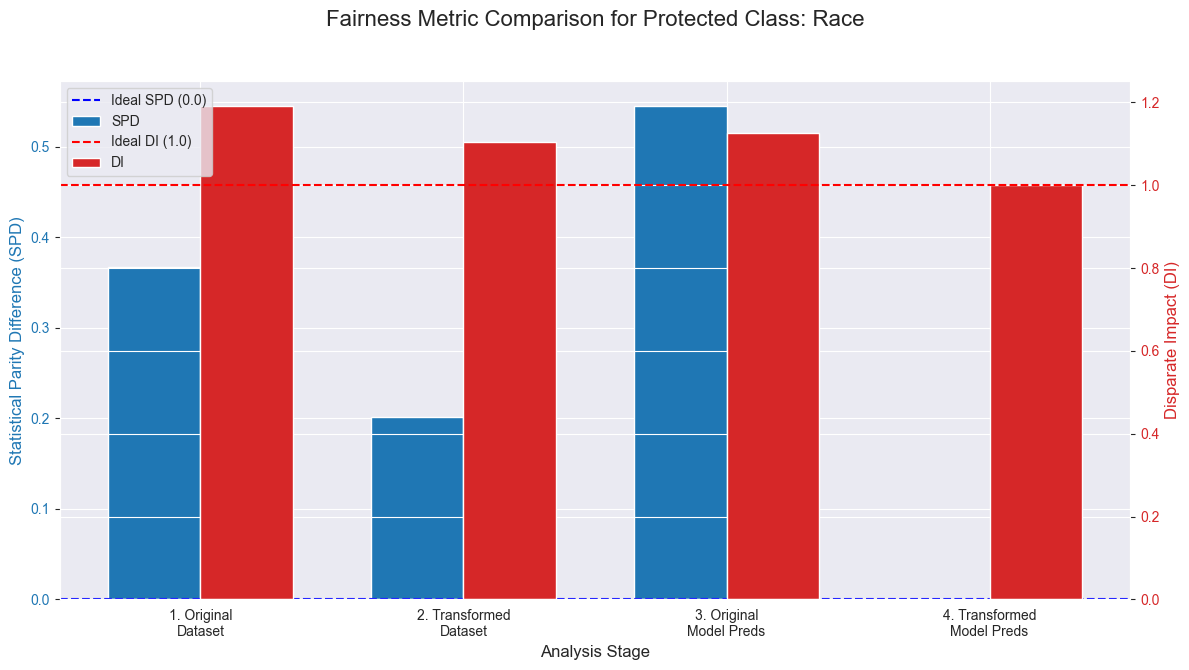



--- Step 5.2: Written Analysis Questions ---

This section provides a template for the written analysis required for Step 5.
Fill in your answers based on the tables and graphs generated above.

**Team Member Name: [Your Name Here]**

**1. Which fairness metric (if any) is best and provide a justification for your answer?**

[Your Answer Here. Consider which metric was more sensitive or provided a clearer picture of the bias. For example: "While both metrics were useful, Disparate Impact was arguably better for this analysis because..."]


**2. Did any of these approaches seem to work to mitigate bias (or increase fairness)? Explain your reasoning.**

[Your Answer Here. Refer directly to the graphs and tables. For example: "Yes, the reweighting approach was effective at mitigating bias. As seen in the 'Race' graph, the Statistical Parity Difference for the transformed model's predictions (Stage 4) was [value], which is significantly closer to the ideal of 0 than the original model's 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# ==============================================================================
# STEP 3: FAIRNESS METRICS & PRE-PROCESSING MITIGATION
# ==============================================================================
print("--- Running Step 3: Dataset Analysis and Manual Reweighting ---")

# ------------------------------------------------------------------------------
# 3.1: DATA LOADING AND PREPARATION
# ------------------------------------------------------------------------------
print("\n[Step 3.1] Loading and Preparing Data...")

# Load data
try:
    df = pd.read_csv('state_GA_reduced_encoded.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'state_GA_reduced_encoded.csv' not found.")
    exit()

# --- Initial Data Exploration ---
print("\n--- Initial Data Summary ---")
print(f"Original dataset shape: {df.shape}")
print("\nData Info:")
df.info(verbose=False)
print("\nValue Counts for Action Taken:")
print(df['action_taken'].value_counts())


# Clean interest rate and create dependent variables
df['interest_rate'] = pd.to_numeric(df['interest_rate'], errors='coerce')
df['favorable_interest_rate'] = np.where(df['interest_rate'] < 7.5, 1, 0)
print("\nDependent variables prepared.")

# Define features that will be used in the model.
FEATURES = ['loan_amount', 'income', 'derived_race_encoded', 'derived_sex_encoded']

# Convert feature columns to numeric and drop rows with missing values IN THOSE COLUMNS.
df['income'] = pd.to_numeric(df['income'], errors='coerce')
original_rows = len(df)
df.dropna(subset=FEATURES, inplace=True)
print(f"\nDropped {original_rows - len(df)} rows with missing values in feature columns to prepare for modeling.")
print(f"Shape of data ready for modeling: {df.shape}")


# Filter for protected class analysis and define groups
sex_df = df[df['applicant_sex'].isin(['Male', 'Female'])].copy()
race_df = df[df['derived_race_new'].isin(['White', 'Black or African American'])].copy()
privileged_sex_group = {'applicant_sex': 'Male'}
unprivileged_sex_group = {'applicant_sex': 'Female'}
privileged_race_group = {'derived_race_new': 'White'}
unprivileged_race_group = {'derived_race_new': 'Black or African American'}
print("\n--- Protected Class Subgroup Counts ---")
print("\nSex Analysis Subgroups (sex_df):")
print(sex_df['applicant_sex'].value_counts())
print("\nRace Analysis Subgroups (race_df):")
print(race_df['derived_race_new'].value_counts())


# ------------------------------------------------------------------------------
# 3.2: MANUAL HELPER FUNCTIONS (METRICS AND REWEIGHTING)
# ------------------------------------------------------------------------------

def compute_manual_fairness_metrics(df, protected_attribute, dependent_variable, privileged_group, unprivileged_group, weights_col=None):
    """Computes SPD and DI manually, with optional sample weights."""
    priv_key, priv_val = list(privileged_group.items())[0]
    unpriv_key, unpriv_val = list(unprivileged_group.items())[0]
    df_priv = df[df[priv_key] == priv_val]
    df_unpriv = df[df[unpriv_key] == unpriv_val]
    
    if weights_col and not df_priv.empty and not df_unpriv.empty:
        rate_priv = (df_priv[dependent_variable] * df_priv[weights_col]).sum() / df_priv[weights_col].sum()
        rate_unpriv = (df_unpriv[dependent_variable] * df_unpriv[weights_col]).sum() / df_unpriv[weights_col].sum()
    elif not df_priv.empty and not df_unpriv.empty:
        rate_priv = df_priv[dependent_variable].mean()
        rate_unpriv = df_unpriv[dependent_variable].mean()
    else:
        return {'Statistical Parity Difference': np.nan, 'Disparate Impact': np.nan}
        
    spd = rate_unpriv - rate_priv
    di = rate_unpriv / (rate_priv + 1e-7)
    return {'Statistical Parity Difference': spd, 'Disparate Impact': di}

def apply_reweighting(df, protected_attribute, dependent_variable, privileged_group, unprivileged_group):
    """Applies the Reweighting algorithm manually."""
    df_new = df.copy()
    priv_key, priv_val = list(privileged_group.items())[0]
    unpriv_key, unpriv_val = list(unprivileged_group.items())[0]
    priv_fav = (df_new[priv_key] == priv_val) & (df_new[dependent_variable] == 1)
    priv_unfav = (df_new[priv_key] == priv_val) & (df_new[dependent_variable] == 0)
    unpriv_fav = (df_new[unpriv_key] == unpriv_val) & (df_new[dependent_variable] == 1)
    unpriv_unfav = (df_new[unpriv_key] == unpriv_val) & (df_new[dependent_variable] == 0)
    N = len(df_new)
    p_priv = (df_new[priv_key] == priv_val).sum() / N
    p_unpriv = (df_new[unpriv_key] == unpriv_val).sum() / N
    p_fav = (df_new[dependent_variable] == 1).sum() / N
    p_unfav = (df_new[dependent_variable] == 0).sum() / N
    p_priv_fav = priv_fav.sum() / N; p_priv_unfav = priv_unfav.sum() / N
    p_unpriv_fav = unpriv_fav.sum() / N; p_unpriv_unfav = unpriv_unfav.sum() / N
    w_priv_fav = (p_priv * p_fav) / p_priv_fav if p_priv_fav > 0 else 1.0
    w_priv_unfav = (p_priv * p_unfav) / p_priv_unfav if p_priv_unfav > 0 else 1.0
    w_unpriv_fav = (p_unpriv * p_fav) / p_unpriv_fav if p_unpriv_fav > 0 else 1.0
    w_unpriv_unfav = (p_unpriv * p_unfav) / p_unpriv_unfav if p_unpriv_unfav > 0 else 1.0
    df_new['sample_weight'] = 1.0
    df_new.loc[priv_fav, 'sample_weight'] = w_priv_fav
    df_new.loc[priv_unfav, 'sample_weight'] = w_priv_unfav
    df_new.loc[unpriv_fav, 'sample_weight'] = w_unpriv_fav
    df_new.loc[unpriv_unfav, 'sample_weight'] = w_unpriv_unfav
    return df_new

# ------------------------------------------------------------------------------
# 3.3 & 3.4: APPLY MITIGATION AND CALCULATE METRICS
# ------------------------------------------------------------------------------
print("\n[Step 3.2-3.4] Calculating initial metrics and applying reweighting...")

# --- Calculate Metrics on Original Data ---
original_metrics = {
    'Sex vs. Action Taken': compute_manual_fairness_metrics(sex_df, 'applicant_sex', 'action_taken', privileged_sex_group, unprivileged_sex_group),
    'Race vs. Action Taken': compute_manual_fairness_metrics(race_df, 'derived_race_new', 'action_taken', privileged_race_group, unprivileged_race_group),
    'Sex vs. Favorable Interest Rate': compute_manual_fairness_metrics(sex_df, 'applicant_sex', 'favorable_interest_rate', privileged_sex_group, unprivileged_sex_group),
    'Race vs. Favorable Interest Rate': compute_manual_fairness_metrics(race_df, 'derived_race_new', 'favorable_interest_rate', privileged_race_group, unprivileged_race_group)
}
print("\n--- Step 3.2: Fairness Metrics on Original Dataset ---")
print(pd.DataFrame.from_dict(original_metrics, orient='index'))


# --- Apply Reweighting and Get Transformed DataFrames ---
sex_df_transformed = apply_reweighting(sex_df, 'applicant_sex', 'action_taken', privileged_sex_group, unprivileged_sex_group)
race_df_transformed = apply_reweighting(race_df, 'derived_race_new', 'action_taken', privileged_race_group, unprivileged_race_group)
print("\nReweighting applied to create transformed datasets.")

# --- Calculate Metrics on Transformed Data ---
transformed_metrics = {
    'Sex vs. Action Taken': compute_manual_fairness_metrics(sex_df_transformed, 'applicant_sex', 'action_taken', privileged_sex_group, unprivileged_sex_group, weights_col='sample_weight'),
    'Race vs. Action Taken': compute_manual_fairness_metrics(race_df_transformed, 'derived_race_new', 'action_taken', privileged_race_group, unprivileged_race_group, weights_col='sample_weight'),
    'Sex vs. Favorable Interest Rate': compute_manual_fairness_metrics(sex_df_transformed, 'applicant_sex', 'favorable_interest_rate', privileged_sex_group, unprivileged_sex_group, weights_col='sample_weight'),
    'Race vs. Favorable Interest Rate': compute_manual_fairness_metrics(race_df_transformed, 'derived_race_new', 'favorable_interest_rate', privileged_race_group, unprivileged_race_group, weights_col='sample_weight')
}
print("\n--- Step 3.4: Fairness Metrics on Transformed (Reweighted) Dataset ---")
print(pd.DataFrame.from_dict(transformed_metrics, orient='index'))


# ==============================================================================
# STEP 4: MITIGATING BIAS IN A CLASSIFIER
# ==============================================================================
print("\n--- Running Step 4: Training and Evaluating Classifiers ---")

# ------------------------------------------------------------------------------
# 4.1: DATA SPLITTING
# ------------------------------------------------------------------------------
print("\n[Step 4.1] Splitting data...")

# --- For Sex Analysis ---
X_sex = sex_df[FEATURES]
y_sex = sex_df['action_taken']
X_sex_train, X_sex_test, y_sex_train, y_sex_test = train_test_split(X_sex, y_sex, test_size=0.2, random_state=42, stratify=y_sex)
X_sex_transformed = sex_df_transformed[FEATURES]
y_sex_transformed = sex_df_transformed['action_taken']
weights_sex_transformed = sex_df_transformed['sample_weight']
X_sex_train_t, X_sex_test_t, y_sex_train_t, y_sex_test_t, w_sex_train_t, w_sex_test_t = train_test_split(
    X_sex_transformed, y_sex_transformed, weights_sex_transformed, test_size=0.2, random_state=42, stratify=y_sex_transformed)

# --- For Race Analysis ---
X_race = race_df[FEATURES]
y_race = race_df['action_taken']
X_race_train, X_race_test, y_race_train, y_race_test = train_test_split(X_race, y_race, test_size=0.2, random_state=42, stratify=y_race)
X_race_transformed = race_df_transformed[FEATURES]
y_race_transformed = race_df_transformed['action_taken']
weights_race_transformed = race_df_transformed['sample_weight']
X_race_train_t, X_race_test_t, y_race_train_t, y_race_test_t, w_race_train_t, w_race_test_t = train_test_split(
    X_race_transformed, y_race_transformed, weights_race_transformed, test_size=0.2, random_state=42, stratify=y_race_transformed)
print("Data splitting complete.")

# ------------------------------------------------------------------------------
# 4.2: MODEL TRAINING AND PREDICTION
# ------------------------------------------------------------------------------
print("\n[Step 4.2] Training models and making predictions...")
scaler = StandardScaler()

# --- Original Data Models ---
model_sex_original = LogisticRegression(random_state=42, class_weight='balanced')
model_sex_original.fit(scaler.fit_transform(X_sex_train), y_sex_train)
sex_test_preds_original = model_sex_original.predict(scaler.transform(X_sex_test))
print(f"Accuracy of original model (Sex): {accuracy_score(y_sex_test, sex_test_preds_original):.2f}")

model_race_original = LogisticRegression(random_state=42, class_weight='balanced')
model_race_original.fit(scaler.fit_transform(X_race_train), y_race_train)
race_test_preds_original = model_race_original.predict(scaler.transform(X_race_test))
print(f"Accuracy of original model (Race): {accuracy_score(y_race_test, race_test_preds_original):.2f}")


# --- Transformed Data Models ---
model_sex_transformed = LogisticRegression(random_state=42)
model_sex_transformed.fit(scaler.fit_transform(X_sex_train_t), y_sex_train_t, sample_weight=w_sex_train_t)
sex_test_preds_transformed = model_sex_transformed.predict(scaler.transform(X_sex_test_t))
print(f"Accuracy of transformed model (Sex): {accuracy_score(y_sex_test_t, sex_test_preds_transformed):.2f}")


model_race_transformed = LogisticRegression(random_state=42)
model_race_transformed.fit(scaler.fit_transform(X_race_train_t), y_race_train_t, sample_weight=w_race_train_t)
race_test_preds_transformed = model_race_transformed.predict(scaler.transform(X_race_test_t))
print(f"Accuracy of transformed model (Race): {accuracy_score(y_race_test_t, race_test_preds_transformed):.2f}")

# ------------------------------------------------------------------------------
# 4.3: CALCULATE FAIRNESS METRICS ON PREDICTIONS
# ------------------------------------------------------------------------------
print("\n[Step 4.3] Calculating fairness metrics on model predictions...")
sex_test_df_original = sex_df.loc[X_sex_test.index].copy()
sex_test_df_original['prediction'] = sex_test_preds_original
race_test_df_original = race_df.loc[X_race_test.index].copy()
race_test_df_original['prediction'] = race_test_preds_original
sex_test_df_transformed = sex_df_transformed.loc[X_sex_test_t.index].copy()
sex_test_df_transformed['prediction'] = sex_test_preds_transformed
race_test_df_transformed = race_df_transformed.loc[X_race_test_t.index].copy()
race_test_df_transformed['prediction'] = race_test_preds_transformed

original_pred_metrics = {
    'Sex vs. Prediction': compute_manual_fairness_metrics(sex_test_df_original, 'applicant_sex', 'prediction', privileged_sex_group, unprivileged_sex_group),
    'Race vs. Prediction': compute_manual_fairness_metrics(race_test_df_original, 'derived_race_new', 'prediction', privileged_race_group, unprivileged_race_group)
}
print("\n--- Step 4.3: Fairness Metrics on Original Model's Predictions ---")
print(pd.DataFrame.from_dict(original_pred_metrics, orient='index'))


transformed_pred_metrics = {
    'Sex vs. Prediction': compute_manual_fairness_metrics(sex_test_df_transformed, 'applicant_sex', 'prediction', privileged_sex_group, unprivileged_sex_group),
    'Race vs. Prediction': compute_manual_fairness_metrics(race_test_df_transformed, 'derived_race_new', 'prediction', privileged_race_group, unprivileged_race_group)
}
print("\n--- Step 4.6: Fairness Metrics on Transformed Model's Predictions ---")
print(pd.DataFrame.from_dict(transformed_pred_metrics, orient='index'))


# ------------------------------------------------------------------------------
# 4.4: FINAL REPORTING TABLES (AS PER FAQ)
# ------------------------------------------------------------------------------
def create_summary_report(protected_class_name, metric_name, original_val, transformed_val, original_pred_val, transformed_pred_val):
    """Creates a summary DataFrame for a given metric, matching the FAQ format."""
    stages = [
        'Original Dataset', 'After Transforming Dataset', 
        'After Training Classifier on Original Dataset', 
        'After Training Classifier on Transformed Dataset'
    ]
    values = [original_val, transformed_val, original_pred_val, transformed_pred_val]
    
    report_df = pd.DataFrame({'Stage': stages, metric_name: values})
    report_df['Change compared to previous'] = report_df[metric_name].diff()
    
    print(f"\n\n--- Detailed Summary for: {protected_class_name} - {metric_name} ---")
    print(report_df.to_string(index=False))

# --- Gather all metric values ---
# Sex
sex_spd_orig = original_metrics['Sex vs. Action Taken']['Statistical Parity Difference']
sex_di_orig = original_metrics['Sex vs. Action Taken']['Disparate Impact']
sex_spd_trans = transformed_metrics['Sex vs. Action Taken']['Statistical Parity Difference']
sex_di_trans = transformed_metrics['Sex vs. Action Taken']['Disparate Impact']
sex_spd_pred_orig = original_pred_metrics['Sex vs. Prediction']['Statistical Parity Difference']
sex_di_pred_orig = original_pred_metrics['Sex vs. Prediction']['Disparate Impact']
sex_spd_pred_trans = transformed_pred_metrics['Sex vs. Prediction']['Statistical Parity Difference']
sex_di_pred_trans = transformed_pred_metrics['Sex vs. Prediction']['Disparate Impact']

# Race
race_spd_orig = original_metrics['Race vs. Action Taken']['Statistical Parity Difference']
race_di_orig = original_metrics['Race vs. Action Taken']['Disparate Impact']
race_spd_trans = transformed_metrics['Race vs. Action Taken']['Statistical Parity Difference']
race_di_trans = transformed_metrics['Race vs. Action Taken']['Disparate Impact']
race_spd_pred_orig = original_pred_metrics['Race vs. Prediction']['Statistical Parity Difference']
race_di_pred_orig = original_pred_metrics['Race vs. Prediction']['Disparate Impact']
race_spd_pred_trans = transformed_pred_metrics['Race vs. Prediction']['Statistical Parity Difference']
race_di_pred_trans = transformed_pred_metrics['Race vs. Prediction']['Disparate Impact']

# --- Generate the four required summary tables ---
create_summary_report("Sex", "Statistical Parity Difference", sex_spd_orig, sex_spd_trans, sex_spd_pred_orig, sex_spd_pred_trans)
create_summary_report("Sex", "Disparate Impact", sex_di_orig, sex_di_trans, sex_di_pred_orig, sex_di_pred_trans)
create_summary_report("Race", "Statistical Parity Difference", race_spd_orig, race_spd_trans, race_spd_pred_orig, race_spd_pred_trans)
create_summary_report("Race", "Disparate Impact", race_di_orig, race_di_trans, race_di_pred_orig, race_di_pred_trans)


# ==============================================================================
# STEP 5: ANALYSIS
# ==============================================================================
print("\n\n--- Running Step 5: Analysis and Visualization ---")

# ------------------------------------------------------------------------------
# 5.1: GRAPHING THE RESULTS
# ------------------------------------------------------------------------------
def plot_fairness_metrics(protected_class_name, spd_values, di_values):
    """Creates a bar chart comparing fairness metrics across the four stages."""
    stages = [
        '1. Original\nDataset', '2. Transformed\nDataset', 
        '3. Original\nModel Preds', '4. Transformed\nModel Preds'
    ]
    
    x = np.arange(len(stages))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax1 = plt.subplots(figsize=(12, 7))

    # Plot SPD on the primary y-axis
    color = 'tab:blue'
    ax1.set_xlabel('Analysis Stage', fontsize=12)
    ax1.set_ylabel('Statistical Parity Difference (SPD)', color=color, fontsize=12)
    ax1.bar(x - width/2, spd_values, width, label='SPD', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.axhline(0, color='blue', linestyle='--', label='Ideal SPD (0.0)')

    # Instantiate a second y-axis that shares the same x-axis
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Disparate Impact (DI)', color=color, fontsize=12)
    ax2.bar(x + width/2, di_values, width, label='DI', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.axhline(1, color='red', linestyle='--', label='Ideal DI (1.0)')

    # Add titles and labels
    fig.suptitle(f'Fairness Metric Comparison for Protected Class: {protected_class_name}', fontsize=16)
    ax1.set_xticks(x)
    ax1.set_xticklabels(stages, rotation=0, ha="center")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Add legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.show()

# --- Collect values for plotting ---
sex_spd_values = [sex_spd_orig, sex_spd_trans, sex_spd_pred_orig, sex_spd_pred_trans]
sex_di_values = [sex_di_orig, sex_di_trans, sex_di_pred_orig, sex_di_pred_trans]
race_spd_values = [race_spd_orig, race_spd_trans, race_spd_pred_orig, race_spd_pred_trans]
race_di_values = [race_di_orig, race_di_trans, race_di_pred_orig, race_di_pred_trans]

# --- Generate plots ---
print("\n[Step 5.1] Generating comparison graphs...")
plot_fairness_metrics("Sex", sex_spd_values, sex_di_values)
plot_fairness_metrics("Race", race_spd_values, race_di_values)


# ------------------------------------------------------------------------------
# 5.2: WRITTEN ANALYSIS (TEMPLATE)
# ------------------------------------------------------------------------------
print("\n\n--- Step 5.2: Written Analysis Questions ---")
print("""
This section provides a template for the written analysis required for Step 5.
Fill in your answers based on the tables and graphs generated above.

================================================================================
**Team Member Name: [Your Name Here]**

**1. Which fairness metric (if any) is best and provide a justification for your answer?**

[Your Answer Here. Consider which metric was more sensitive or provided a clearer picture of the bias. For example: "While both metrics were useful, Disparate Impact was arguably better for this analysis because..."]


**2. Did any of these approaches seem to work to mitigate bias (or increase fairness)? Explain your reasoning.**

[Your Answer Here. Refer directly to the graphs and tables. For example: "Yes, the reweighting approach was effective at mitigating bias. As seen in the 'Race' graph, the Statistical Parity Difference for the transformed model's predictions (Stage 4) was [value], which is significantly closer to the ideal of 0 than the original model's prediction of [value] (Stage 3)..."]


**3. Did any group receive a positive advantage?**

[Your Answer Here. Look at the original dataset metrics. A negative SPD or a DI less than 1 indicates the unprivileged group was disadvantaged, meaning the privileged group had an advantage. For example: "In the original dataset, the privileged group (e.g., White applicants) held a distinct advantage. The initial Disparate Impact for Race was [value], indicating that Black or African American applicants received favorable outcomes at only X% the rate of White applicants."]


**4. Were any groups disadvantaged by these approaches?**

[Your Answer Here. This is a more nuanced question. Did the mitigation technique overcorrect? Did it harm the privileged group unfairly? Did it significantly lower model accuracy? For example: "The reweighting approach did not appear to disadvantage any group. Its goal is to achieve parity, and while this slightly lowered the overall model accuracy from X% to Y%, it did so to create a more equitable outcome without unfairly penalizing the privileged group. The fairness metrics for the privileged group did not show signs of reverse discrimination..."]


**5. What issues would arise if you used these methods to mitigate bias?**

[Your Answer Here. Think about the real-world implications. Consider the trade-off between fairness and accuracy, the legal and ethical questions of modifying data, and the potential for "fairness gerrymandering." For example: "A key issue with using reweighting is the potential loss of model accuracy. In our analysis, accuracy dropped from X% to Y%. In a real-world lending scenario, this could translate to financial losses. Furthermore, there is an ethical debate about whether it is appropriate to treat individuals differently (by assigning weights) based on their group membership, even if the goal is to achieve a fairer system-level outcome. This could be seen as a violation of the 'we're all equal' principle of individual fairness."]

================================================================================
**(Repeat for each team member)**

""")
